# Chapter 7.2 

We now apply deep learning models to limit order books data and build a predictive signal.

We can network architecture DeepLOB here to predict future returns defined by mid-price. The decimal precision normalization is applied. 

DeepLOB: https://github.com/zcakhaa/DeepLOB-Deep-Convolutional-Neural-Networks-for-Limit-Order-Books


In [1]:
import os 
import sys
current_dir = os.path.dirname(os.path.abspath("__file__"))
project_dir = os.path.dirname(current_dir)
sys.path.append(project_dir)

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import mean_squared_error
from Utilis.early_stopper import EarlyStopping
from Utilis.torch_data import MyDataset

In [2]:
class deeplob(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.device = device
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,10)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )
        
        self.inp1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp3 = nn.Sequential(
            nn.MaxPool2d((3, 1), stride=(1, 1), padding=(1, 0)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        
        # lstm layers
        self.lstm = nn.LSTM(input_size=192, hidden_size=64, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(64, 1)

    def forward(self, x):
        # h0: (number of hidden layers, batch size, hidden size)
        h0 = torch.zeros(1, x.size(0), 64).to(self.device)
        c0 = torch.zeros(1, x.size(0), 64).to(self.device)

        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x_inp1 = self.inp1(x)
        x_inp2 = self.inp2(x)
        x_inp3 = self.inp3(x)  
        
        x = torch.cat((x_inp1, x_inp2, x_inp3), dim=1)
        
        x = x.permute(0, 2, 1, 3)
        x = torch.reshape(x, (-1, x.shape[1], x.shape[2]))
        
        x, _ = self.lstm(x, (h0, c0))
        x = x[:, -1, :]
        x = self.fc1(x)[:,0]        
        return x

In [3]:
def train_model(model, train_data_loader, val_data_loader, X_test, savepath, epochs=5, lr=1e-3, patience=5):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    early_stopper = EarlyStopping(savepath=savepath, patience=patience, min_delta=1e-4, verbose=True)
    for epoch in range(epochs):
        train_epoch_loss = []
        val_epoch_loss = []
        
        model.train()
        for batch_X, batch_y in train_data_loader:
            optimizer.zero_grad()
            out = model(batch_X)
            loss = criterion(out, batch_y)
            loss.backward()
            optimizer.step()
            train_epoch_loss.append(loss.item())

        model.eval()
        for batch_X, batch_y in val_data_loader:
            with torch.no_grad():
                out = model(batch_X)
                loss = criterion(out, batch_y)
                val_epoch_loss.append(loss.item())
        
        train_epoch_loss = np.mean(train_epoch_loss)
        val_epoch_loss = np.mean(val_epoch_loss)

        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train loss: {train_epoch_loss:.4f}, "
              f"Validation loss: {val_epoch_loss:.4f}")
        
        early_stopper(model, val_epoch_loss)
        if early_stopper.early_stop:
            print("Early stopping triggered!")
            break
    
    model.load_state_dict(torch.load(savepath))
    model.eval()
    y_pred_test = model(torch.from_numpy(X_test.astype(np.float32)))
    return model, y_pred_test.detach().cpu().numpy()           

In [4]:
def data_classification(X, Y, T):
    [N, D] = X.shape
    df = np.array(X)
    dY = np.array(Y)
    dataY = dY[T - 1:N]
    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]
    return dataX, dataY

In [5]:
COLsP = sum([['AskPrice'+str(i), 'BidPrice'+str(i)] for i in range(1, 11)], [])
COLsV = sum([['AskVolume'+str(i), 'BidVolume'+str(i)] for i in range(1, 11)], [])

In [6]:
df = pd.read_csv('../Data/limit_order_book_data.csv')
df['MidPrice'] = (df['AskPrice1'] + df['BidPrice1']) / 2
df['Target'] = np.log(df['MidPrice'].shift(-10) / df['MidPrice']) * 10
df = df.dropna()
df_nor = df.drop(columns=['MidPrice', 'Target'])
df_nor[COLsP] = df_nor[COLsP] / 10
df_nor[COLsV] = df_nor[COLsV] / 10000
print(df_nor.shape)


(22990, 40)


In [7]:
train_size = int(0.6*len(df_nor))
val_size = int(0.8*len(df_nor))
T = 30

train_x, train_y = data_classification(df_nor[:train_size], df['Target'][:train_size], T)
val_x, val_y = data_classification(df_nor[train_size:val_size], df['Target'][train_size:val_size], T)
test_x, test_y = data_classification(df_nor[val_size:], df['Target'][val_size:], T)

print(train_x.shape, train_y.shape)
print(val_x.shape, val_y.shape)
print(test_x.shape, test_y.shape)


(13765, 30, 40) (13765,)
(4569, 30, 40) (4569,)
(4569, 30, 40) (4569,)


In [8]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=MyDataset(train_x, train_y), batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=MyDataset(val_x, val_y), batch_size=batch_size, shuffle=False)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = deeplob(device)
model.to(device)
model, y_pred = train_model(model, train_loader, val_loader, test_x, savepath='./model/best_model', epochs=1, lr=0.001, patience=20)

Using device: cpu
Epoch 1/1, Train loss: 0.0019, Validation loss: 0.0005


In [15]:
mse = mean_squared_error(test_y, y_pred)
print(mse)


0.0002870775220355663


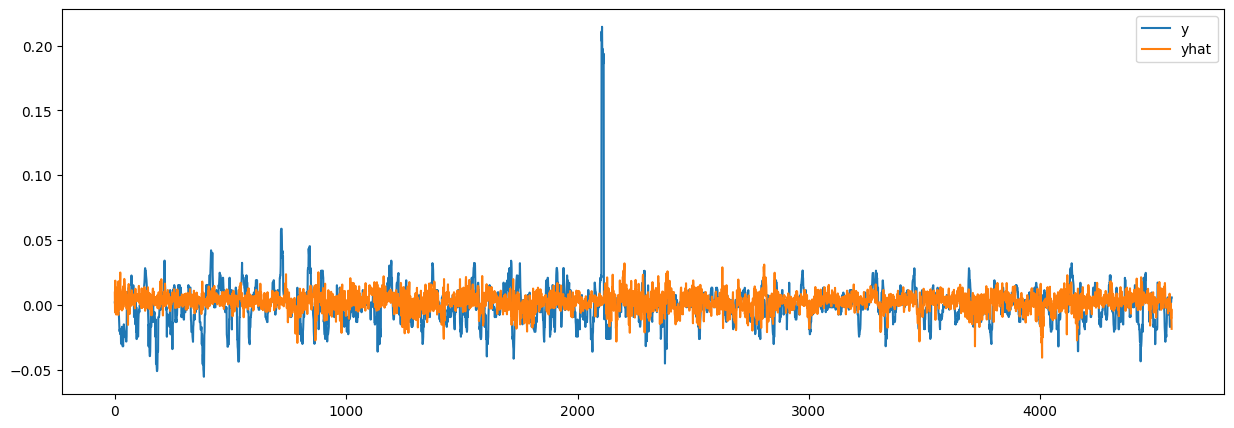

In [14]:
plt.figure(figsize=(15,5))
plt.plot(test_y, label='y')
plt.plot(y_pred, label='yhat')
plt.legend()